In [ ]:
#!pip install opencv-python matplotlib
#!pip install datasets

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# Import uuid library to generate unique image names
import uuid

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2024-12-15 03:37:59.412375: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-12-15 03:37:59.412395: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: cityhunter
2024-12-15 03:37:59.412399: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: cityhunter
2024-12-15 03:37:59.412497: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2024-12-15 03:37:59.412509: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2024-12-15 03:37:59.412511: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [326]:
# Make the directories
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [327]:
# http://vis-www.cs.umass.edu/lfw/

In [318]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz

In [319]:
# Move LFW Images to the following repository data/negative
#for directory in os.listdir('lfw'):
 #   for file in os.listdir(os.path.join('lfw', directory)):
  #      EX_PATH = os.path.join('lfw', directory, file)
   #     NEW_PATH = os.path.join(NEG_PATH, file)
    #    os.replace(EX_PATH, NEW_PATH)

In [320]:
#os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [321]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('s'):
        # Create the unique file path q
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [12]:
#plt.imshow(frame[120:120+250,200:200+250, :])

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data/anchor/6014ce26-bab3-11ef-88b5-346f24e2e2c7.jpg'


In [10]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the image to be 105x105x3
    img = tf.image.resize(img, (105, 105))
    # Scale image to be between 0 and 1
    img = img / 255.0
    # Return image
    return img

In [11]:
img = preprocess('data/anchor/60de2a46-bab3-11ef-88b5-346f24e2e2c7.jpg')

In [12]:
img.numpy().max() 

np.float32(0.99748564)

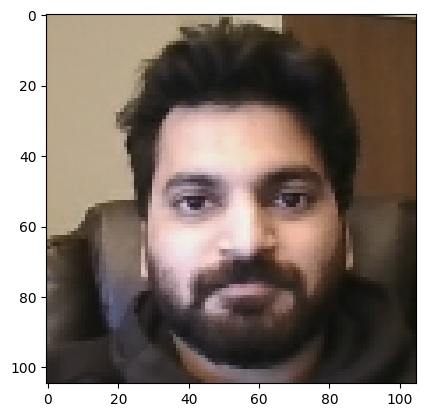

In [13]:
plt.imshow(img)

In [14]:
data = anchor.concatenate(positive).concatenate(negative)
data = data.map(preprocess)

In [15]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
exampple = samples.next()

In [19]:
exampple

(b'data/anchor/5e8ba750-bab3-11ef-88b5-346f24e2e2c7.jpg',
 b'data/positive/fda11a9c-bab2-11ef-88b5-346f24e2e2c7.jpg',
 np.float32(1.0))

In [20]:
# Update the preprocess_twin function to include the correct resizing
def preprocess_twin(input_img, validation_img, label):
    # Preprocess both input images and return them along with the label
    return preprocess(input_img), preprocess(validation_img), label

In [21]:
res = preprocess_twin(*exampple)

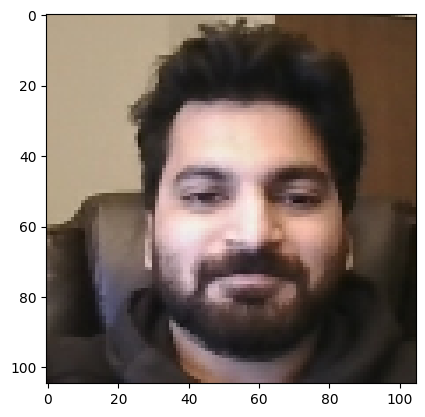

In [47]:
plt.imshow(res[1])

In [48]:
res[2]

np.float32(1.0)

In [49]:
# Fix the data pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

TypeError: in user code:

    File "/tmp/ipykernel_174556/831442053.py", line 4, in preprocess_twin  *
        return preprocess(input_img), preprocess(validation_img), label
    File "/tmp/ipykernel_174556/525551673.py", line 3, in preprocess  *
        byte_img = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [ ]:
# Training partition
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [50]:
# Testing partition
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [51]:
inp = Input(shape=(105,105,3), name='input_image')

In [52]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [53]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [54]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [55]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [56]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [57]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [58]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [60]:
embedding = make_embedding()

In [61]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Your custom L1 distance layer class
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        # Ensure that embeddings are tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)

In [63]:
def verify(model, input_image_path, verification_image_path, threshold=0.9):
    # Load and preprocess the input and verification images
    input_image = preprocess(input_image_path)
    verification_image = preprocess(verification_image_path)
    
    # Generate embeddings for both images
    input_embedding = embedding(input_image)
    verification_embedding = embedding(verification_image)
    
    # Instantiate the L1Dist layer
    l1_dist_layer = L1Dist()

    # Calculate the L1 distance between the embeddings using your custom layer
    distance = l1_dist_layer(input_embedding, verification_embedding)
    
    # Now `distance` is the L1 distance tensor. Since this distance is a measure of similarity, 
    # it might be a value from a distance function that would usually be passed to a model for comparison.
    
    # For simplicity, if the model output is a binary classification, we can apply a threshold on the distance:
    similarity_score = model(distance)  # the model should output a similarity score between 0 and 1

    # The model's output could be a probability (for binary classification, similarity score)
    return similarity_score.numpy() > threshold  # Use threshold to decide if the images are a match


In [64]:
l1 = L1Dist()

In [65]:
anchor_embedding = embedding(input_image)
validation_embedding = embedding(validation_image)
l1 = L1Dist()
l1(anchor_embedding, validation_embedding)

<KerasTensor shape=(1, None, 4096), dtype=float32, sparse=False, name=keras_tensor_41>

In [66]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [67]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [68]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

In [69]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_45>

In [70]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [71]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_5 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [73]:
siamese_model = make_siamese_model()

In [74]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_6 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[4][0],  │
│                     │                   │            │ embedding[5][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
#TRAINING

In [76]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [77]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [78]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [79]:
test_batch = train_data.as_numpy_iterator()

In [80]:
batch_1 = test_batch.next()

In [81]:
X = batch_1[:2]

In [82]:
y = batch_1[2]

In [83]:
y

array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [84]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [85]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Unpack the batch
        X = batch[:2]  # These are the input images (anchor and positive/negative images)
        y = batch[2]   # This is the label (0 or 1 for similarity)

        # Get the model prediction
        yhat = siamese_model(X, training=True)

        # Check the shape of yhat and adjust
        print(f"yhat shape before squeeze/reshape: {yhat.shape}")  # Debug print
        
        # Squeeze or reshape yhat to match the shape of y (which should be (batch_size,))
        yhat = tf.reshape(yhat, (-1,))  # Reshape to (batch_size,)
        
        print(f"yhat shape after reshape: {yhat.shape}")  # Debug print
        
        # Reshape y to ensure it's of shape (batch_size,)
        y = tf.reshape(y, (-1,))  # Ensures that y is of shape (batch_size,)
        
        # Ensure the shapes are now compatible
        assert y.shape == yhat.shape, f"Shape mismatch: y={y.shape}, yhat={yhat.shape}"

        # Compute the loss
        loss = binary_cross_loss(y, yhat)

    # Compute gradients and apply updates
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [86]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [87]:
EPOCHS = 50

In [88]:
train(train_data, EPOCHS)


 Epoch 1/50
yhat shape before squeeze/reshape: (1, 16, 1)
yhat shape after reshape: (16,)


/home/cityhunter/anaconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 105, 105, 3))
  warnings.warn(msg)


yhat shape before squeeze/reshape: (1, 16, 1)
yhat shape after reshape: (16,)
18/19 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepyhat shape before squeeze/reshape: (1, 9, 1)
yhat shape after reshape: (9,)


/home/cityhunter/anaconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(9, 105, 105, 3))
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

 Epoch 2/50


2024-12-15 03:40:11.733230: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 3/50


2024-12-15 03:40:35.426649: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 5/50


2024-12-15 03:41:22.953496: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 9/50


2024-12-15 03:42:57.695232: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 16/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

 Epoch 17/50


2024-12-15 03:46:08.571079: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 18/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

 Epoch 19/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 20/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 21/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 22/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 23/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 24/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 25/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 26/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 27/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

 Epoch 28/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 29/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 30/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

 Epoch 31/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 32/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 33/50


2024-12-15 03:52:34.589409: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 34/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

 Epoch 35/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 36/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 37/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

 Epoch 38/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 39/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 40/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 41/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 42/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 43/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 44/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 45/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

 Epoch 46/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 47/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

 Epoch 48/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

 Epoch 49/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

 Epoch 50/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


In [90]:
#Evaluate Model

In [91]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [92]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


array([[[1.2170807e-07],
        [9.9999213e-01],
        [1.0000000e+00],
        [5.4334553e-08],
        [9.9999976e-01],
        [1.3367623e-08],
        [8.7727359e-10],
        [4.2536551e-11],
        [7.2544324e-08],
        [7.5466439e-11],
        [1.4930006e-10],
        [1.8873475e-10],
        [3.2985943e-07],
        [9.9999869e-01],
        [5.9591367e-11],
        [1.6131575e-11]]], dtype=float32)

In [93]:
# # Post-processing the results 
# y_hat_binary = [1 if prediction > 0.5 else 0 for prediction in y_hat.flatten()]  # Flatten and compare
# # # OR you can also use numpy's where method for this:
# # y_hat_binary = np.where(y_hat > 0.5, 1, 0)
# # y_hat_binary


In [94]:
# Post-processing with tf.where
y_pred = tf.where(y_hat > 0.9, 1, 0)

In [95]:
y_true

array([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [96]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [97]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [101]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1.0 1.0


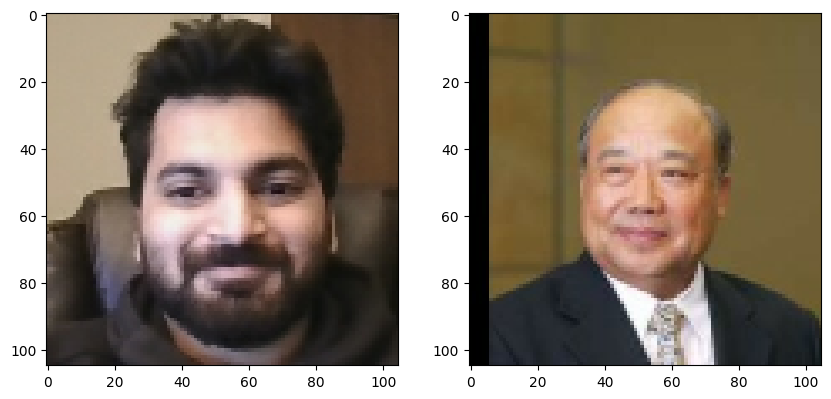

In [102]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

In [103]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [104]:
L1Dist

__main__.L1Dist

In [105]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [106]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


array([[[3.7077155e-10],
        [6.8563105e-10],
        [2.8457019e-09],
        [9.9999911e-01],
        [4.8471329e-09],
        [9.9999827e-01],
        [1.1951862e-09],
        [3.0641467e-09],
        [8.6540952e-09],
        [2.2539703e-10],
        [1.9554712e-08],
        [4.6855856e-11],
        [9.9999988e-01],
        [9.9999982e-01],
        [5.0617216e-10]]], dtype=float32)

In [107]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_7 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
#application_data\verification_images

In [109]:
os.listdir(os.path.join('application_data', 'verification_images'))

['34ae2fe8-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '30b484aa-bab3-11ef-88b5-346f24e2e2c7.jpg',
 'f223d5b0-bab2-11ef-88b5-346f24e2e2c7.jpg',
 'e98fc2ba-bab2-11ef-88b5-346f24e2e2c7.jpg',
 '414f360c-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '4718a032-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '0932a83a-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '25a5f328-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '3ab34c20-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '271afe24-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '216fface-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '2980d44a-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '30f11f46-bab3-11ef-88b5-346f24e2e2c7.jpg',
 'fb44d950-bab2-11ef-88b5-346f24e2e2c7.jpg',
 'd212af08-bab2-11ef-88b5-346f24e2e2c7.jpg',
 '2f902444-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '0feceec4-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '4090258c-bab3-11ef-88b5-346f24e2e2c7.jpg',
 'eabdb34a-bab2-11ef-88b5-346f24e2e2c7.jpg',
 '21e8d156-bab3-11ef-88b5-346f24e2e2c7.jpg',
 'dc39203e-bab2-11ef-88b5-346f24e2e2c7.jpg',
 '040af312-bab3-11ef-88b5-346f24e2e2c7.jpg',
 '312d8314

In [110]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [111]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/34ae2fe8-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/30b484aa-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/f223d5b0-bab2-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/e98fc2ba-bab2-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/414f360c-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/4718a032-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/0932a83a-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/25a5f328-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/3ab34c20-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/271afe24-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/216fface-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/2980d44a-bab3-11ef-88b5-346f24e2e2c7.jpg
application_data/verification_images/30f11f46-bab3-11ef-88b5-346

In [112]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified


In [113]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━

In [114]:
result=np.sum(np.squeeze(results) > 0.8)

In [115]:
result

np.int64(122)

In [116]:
print(90/50)

1.8


In [ ]:
#This works